In [63]:
import os
import json
import numpy as np
from tifffile import imread
import cv2
import skimage.io as sio

import albumentations as A
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection import MaskRCNN, FasterRCNN_ResNet50_FPN_Weights, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import ResNet50_Weights
from torchvision.ops import box_convert
import torchvision.transforms as T
import torch.nn.functional as F

import torch
from torch.optim import SGD, lr_scheduler

import pathlib
import json

from tqdm.auto import tqdm
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from pycocotools.cocoeval import COCOeval

from PIL import Image

from matplotlib import pyplot as plt

In [64]:
# !gdown https://drive.google.com/file/d/1B0qWNzQZQmfQP7x7o4FDdgb9GvPDoFzI/view --fuzzy
# !mkdir ../dataset
# !tar -xzf hw3-data-release.tar.gz
# !mv test_release/ ../dataset
# !mv train/ ../dataset/
# !mv test_image_name_to_ids.json ../dataset/

In [65]:
import numpy as np
import skimage.io as sio
from pycocotools import mask as mask_utils


def decode_maskobj(mask_obj):
    return mask_utils.decode(mask_obj)


def encode_mask(binary_mask):
    arr = np.asfortranarray(binary_mask).astype(np.uint8)
    rle = mask_utils.encode(arr)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle


def read_maskfile(filepath):
    mask_array = sio.imread(filepath)
    return mask_array

In [66]:
all_img_size = [446, 512]

In [67]:
class MedicalDataset(Dataset):
    def __init__(self, root_dir, transform=None, data_type='Train'):
        self.root = root_dir
        self.transform = transform
        self.data_type = data_type
        if self.data_type not in ['Train', 'Valid', 'Test']:
            raise ValueError('Data type should be in [Train, Valid, Test]')
        self.samples = self._load_samples()

        self.train_coco_path = os.path.join(pathlib.Path(root_dir).parent, 'train_coco.json')
        self.val_coco_path = os.path.join(pathlib.Path(root_dir).parent, 'val_coco.json')
        self.test_json_path = os.path.join(pathlib.Path(root_dir).parent, 'test_image_name_to_ids.json')
        if not os.path.exists(self.train_coco_path) or not os.path.exists(self.val_coco_path):
            self.generate_coco_split_new(self.train_coco_path, self.val_coco_path, split_ratio=0.8)
            # self.generate_coco_split(self.train_coco_path, self.val_coco_path, split_ratio=0.8)
        self.train_coco = COCO(self.train_coco_path)
        self.val_coco = COCO(self.val_coco_path)

        self.num_classes = len(self.train_coco.loadCats(self.train_coco.getCatIds()))

    def _load_samples(self):
        samples = []
        for img_dir in os.listdir(self.root):
            tmp_dir = os.path.join(self.root, img_dir)

            if self.data_type == 'Train' or self.data_type == 'Valid':
                img_path = os.path.join(tmp_dir, 'image.tif')

                mask_paths = [
                    entry.name for entry in pathlib.Path(tmp_dir).iterdir()
                    if entry.name.startswith("class") and entry.is_file()
                ]

                samples.append({'image': img_path, 'masks': mask_paths})
            elif self.data_type == 'Test':
                test_img_json_path = os.path.join(pathlib.Path(self.root).parent, 'test_image_name_to_ids.json')
                with open(test_img_json_path, 'r') as f:
                    samples = json.load(f)

            else:
                raise ValueError('Wrong data type')

                # for idx in range(len(samples)):
                #     samples[idx]['file_name'] = os.path.join(self.root, samples[idx]['file_name'])
        return samples

    def mask_to_polygons(self, mask, epsilon=1.0):
        contours,_ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours:
            if len(contour) > 2:
                poly = contour.reshape(-1).tolist()
                if len(poly) > 4: #Ensures valid polygon
                    polygons.append(poly)
        return polygons

    def generate_coco_split_new(self, train_coco_path, val_coco_path, split_ratio=0.8):
        train_data = {"images": [], "annotations": [], "categories": []}
        val_data = {"images": [], "annotations": [], "categories": []}
        all_labels = []
        ann_id = 0
        train_ann = 0
        val_ann = 0

        # 隨機分離樣本索引
        indices = list(range(len(self.samples)))
        import random
        seed = 123
        random.Random(seed).shuffle(indices)
        split_point = int(len(indices) * split_ratio)
        train_indices = indices[:split_point]
        val_indices = indices[split_point:]

        for dataset_type, indices in [("train", train_indices), ("val", val_indices)]:
            target_data = train_data if dataset_type == "train" else val_data

            for idx in indices:
                sample = self.samples[idx]
                img_path, mask_paths = sample['image'], sample['masks']
                img = cv2.imread(img_path)
                masks = [cv2.imread(os.path.join(pathlib.Path(img_path).parent, mask_path), cv2.IMREAD_UNCHANGED) for mask_path in mask_paths]

                image_entry = {
                    "id": idx,
                    "file_name": img_path,
                    "height": img.shape[0],
                    "width": img.shape[1]
                }
                target_data["images"].append(image_entry)

                for mask in masks:
                    unique_values = np.unique(mask)
                    # all_labels.append(unique_values)
                    for value in unique_values:
                        if value == 0:  # Ignore background
                            continue

                        mask_ = cv2.resize(
                            mask,
                            (all_img_size[1], all_img_size[0]),
                            interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                        )

                        object_mask = (mask_ == value).astype(np.uint8) * 255
                        polygons = self.mask_to_polygons(object_mask)

                        for poly in polygons:
                            # ann_id += 1
                            if dataset_type == 'train':
                                train_ann += 1
                                ann_id = train_ann
                            else:
                                val_ann += 1
                                ann_id = val_ann

                            target_data["annotations"].append({
                                "id": ann_id,
                                "image_id": idx,
                                # "category_id": int(value),  # Only one category: Nuclei
                                "category_id": 1,  # Only one category: Nuclei
                                "segmentation": [poly],
                                "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                                "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                                "iscrowd": 0
                            })

        # all_labels = np.unique(np.concatenate(all_labels).tolist())

        categories = [{"id": 1, "name": "Nuclei"}]
        # for idx, label in enumerate(all_labels):
        #     categories.append({"id": idx+1, "name": int(label)})
        train_data["categories"] = categories
        val_data["categories"] = categories


        # coco_input = {
        #     "images": images,
        #     "annotations": annotations,
        #     "categories": categories
        # }

        print(f'Saving coco json')

        with open(train_coco_path, 'w') as f:
            json.dump(train_data, f)
        with open(val_coco_path, 'w') as f:
            json.dump(val_data, f)

    def generate_coco_split(self, train_coco_path, val_coco_path, split_ratio=0.8):
        train_data = {"images": [], "annotations": [], "categories": []}
        val_data = {"images": [], "annotations": [], "categories": []}
        all_labels = []
        ann_id = 0
        train_ann = 0
        val_ann = 0

        # 隨機分離樣本索引
        indices = list(range(len(self.samples)))
        import random
        seed = 123
        random.Random(seed).shuffle(indices)
        split_point = int(len(indices) * split_ratio)
        train_indices = indices[:split_point]
        val_indices = indices[split_point:]

        for dataset_type, indices in [("train", train_indices), ("val", val_indices)]:
            target_data = train_data if dataset_type == "train" else val_data

            for idx in indices:
                sample = self.samples[idx]
                img_path, mask_paths = sample['image'], sample['masks']
                img = cv2.imread(img_path)
                masks = [cv2.imread(os.path.join(pathlib.Path(img_path).parent, mask_path), cv2.IMREAD_UNCHANGED) for mask_path in mask_paths]

                image_entry = {
                    "id": idx,
                    "file_name": img_path,
                    "height": img.shape[0],
                    "width": img.shape[1]
                }
                target_data["images"].append(image_entry)

                for mask in masks:
                    unique_values = np.unique(mask)
                    # all_labels.append(unique_values)
                    for value in unique_values:
                        if value == 0:  # Ignore background
                            continue

                        object_mask = (mask == value).astype(np.uint8) * 255
                        polygons = self.mask_to_polygons(object_mask)

                        for poly in polygons:
                            # ann_id += 1
                            if dataset_type == 'train':
                                train_ann += 1
                                ann_id = train_ann
                            else:
                                val_ann += 1
                                ann_id = val_ann

                            target_data["annotations"].append({
                                "id": ann_id,
                                "image_id": idx,
                                # "category_id": int(value),  # Only one category: Nuclei
                                "category_id": 1,  # Only one category: Nuclei
                                "segmentation": [poly],
                                "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                                "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                                "iscrowd": 0
                            })

        # all_labels = np.unique(np.concatenate(all_labels).tolist())

        categories = [{"id": 1, "name": "Nuclei"}]
        # for idx, label in enumerate(all_labels):
        #     categories.append({"id": idx+1, "name": int(label)})
        train_data["categories"] = categories
        val_data["categories"] = categories


        # coco_input = {
        #     "images": images,
        #     "annotations": annotations,
        #     "categories": categories
        # }

        print(f'Saving coco json')

        with open(train_coco_path, 'w') as f:
            json.dump(train_data, f)
        with open(val_coco_path, 'w') as f:
            json.dump(val_data, f)


    def poly2mask(self, segmentation, img_size):
        """
        多邊形標註轉二值掩碼
        :param segmentation: COCO格式的多邊形坐標列表 [[x1,y1,x2,y2,...]]
        :param img_size: 目標圖像尺寸 (height, width)
        """
        # 自動檢測標註類型
        if isinstance(segmentation, dict):
            # 處理RLE格式
            return coco_mask.decode(segmentation)
        else:
            # 處理多邊形格式
            rle = coco_mask.frPyObjects(segmentation, img_size[0], img_size[1])
            return coco_mask.decode(rle)

    # New get item
    def __getitem__(self, index):
        if self.data_type == 'Train' or self.data_type == 'Valid':
            coco_file = self.train_coco if self.data_type == 'Train' else self.val_coco
            img_id = coco_file.dataset['images'][index]['id']
            img_ids = coco_file.getImgIds(imgIds=img_id)
            img_info = coco_file.loadImgs(img_ids)
            image = cv2.imread(img_info[0]['file_name'])# / 255.0
            # print(img_info)
            # image = Image.open(img_info[0]['file_name']).convert("RGB")
            image = self.transform(image) if self.transform is not None else image
            # img_size = [img_info[0]['height'], img_info[0]['width']]
            img_size = [image.shape[1], image.shape[2]]


            boxes = []
            masks = []
            labels = []
            ann_ids = coco_file.getAnnIds(imgIds=img_ids)
            annotations = coco_file.loadAnns(ann_ids)
            for ann in annotations:
                boxes.append(ann['bbox'])
                tmp_mask = self.poly2mask(ann['segmentation'], img_size).squeeze()

                # mask_ = cv2.resize(
                #     tmp_mask,
                #     (all_img_size[1], all_img_size[0]),
                #     interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                # )
                # masks.append(mask_)
                masks.append(tmp_mask)
                labels.append(ann["category_id"])

            # boxes = self.resize_box(boxes, img_size, target_size=all_img_size)
            boxes = box_convert(torch.tensor(boxes, dtype=torch.float32), in_fmt='xywh', out_fmt='xyxy')
            # masks = torch.as_tensor(np.array(masks), dtype=torch.bool)

            target = {'boxes': boxes,
                      'masks': torch.as_tensor(np.array(masks), dtype=torch.bool),
                      'labels': torch.as_tensor(np.array(labels), dtype=torch.int64)}

            return img_id, image, target # box -> xyxy
        else:
            test_file=[]
            with open(self.test_json_path, 'r') as f:
                test_file = json.load(f)

            image_id = test_file[index]['id']
            
            image_path = os.path.join(self.root, test_file[index]['file_name'])
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)

            return image_id, image
            raise ValueError('This is test, not yet implement')

    # def __getitem__(self, index):
    #     if self.data_type == 'Train' or self.data_type == 'Valid':
    #         coco_file = self.train_coco if self.data_type == 'Train' else self.val_coco
    #         img_id = coco_file.dataset['images'][index]['id']
    #         img_ids = coco_file.getImgIds(imgIds=img_id)
    #         img_info = coco_file.loadImgs(img_ids)
    #         image = cv2.imread(img_info[0]['file_name'])# / 255.0
    #         # print(img_info)
    #         # image = Image.open(img_info[0]['file_name']).convert("RGB")
    #         image = self.transform(image) if self.transform is not None else image
    #         img_size = [img_info[0]['height'], img_info[0]['width']]


    #         boxes = []
    #         masks = []
    #         labels = []
    #         ann_ids = coco_file.getAnnIds(imgIds=img_ids)
    #         annotations = coco_file.loadAnns(ann_ids)
    #         for ann in annotations:
    #             boxes.append(ann['bbox'])
    #             tmp_mask = self.poly2mask(ann['segmentation'], img_size).squeeze()

    #             mask_ = cv2.resize(
    #                 tmp_mask,
    #                 (all_img_size[1], all_img_size[0]),
    #                 interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
    #             )
    #             masks.append(mask_)
    #             labels.append(ann["category_id"])

    #         boxes = self.resize_box(boxes, img_size, target_size=all_img_size)
    #         boxes = box_convert(torch.tensor(boxes, dtype=torch.float32), in_fmt='xywh', out_fmt='xyxy')
    #         masks = torch.as_tensor(np.array(masks), dtype=torch.bool)

    #         target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32),
    #                   'masks': masks,
    #                   'labels': torch.as_tensor(np.array(labels), dtype=torch.int64)}

    #         return img_id, image, target # box -> xyxy
    #     else:
    #         test_file=[]
    #         with open(self.test_json_path, 'r') as f:
    #             test_file = json.load(f)

    #         image_id = test_file[index]['id']
            
    #         image_path = os.path.join(self.root, test_file[index]['file_name'])
    #         image = Image.open(image_path).convert("RGB")
    #         image = self.transform(image)

    #         return image_id, image
    #         raise ValueError('This is test, not yet implement')

    def resize_box(self, boxes, orig_size, target_size):
        # Eat xywh
        scale_w = target_size[1] / orig_size[1]
        scale_h = target_size[0] / orig_size[0]

        # print(f'scale_w = {target_size[1]} / {orig_size[1]}')
        # print(f'scale_h = {target_size[0]} / {orig_size[0]}')

        # print(f'boxes: {boxes}')
        for box in boxes:
            box[0] *= scale_w  # x
            box[1] *= scale_h  # y
            box[2] *= scale_w  # w
            box[3] *= scale_h  # h
        # boxes[:,0] *= scale_w  # x
        # boxes[:,1] *= scale_h  # y
        # boxes[:,2] *= scale_w  # w
        # boxes[:,3] *= scale_h  # h

        return boxes

    def __len__(self):
        coco_file = self.train_coco if self.data_type == 'Train' else self.val_coco
        return len(coco_file.dataset['images'])

In [68]:
project_root = '..'
train_dir = os.path.join(project_root, 'dataset/train')
val_dir = train_dir
test_dir = os.path.join(project_root, 'dataset/test_release')

In [69]:
# train_transform=T.Compose([
#     T.ToTensor(),
#     T.Resize(size=all_img_size, antialias=True),
#     # T.CenterCrop(size=224),
#     # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# test_set = MedicalDataset(root_dir=test_dir, transform=train_transform, data_type='Test')

# print(test_set[20])

In [70]:
# train_transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.3),
#     A.Rotate(limit=15, p=0.4),
#     A.CLAHE(p=0.5),
#     A.GridDistortion(p=0.2),
#     A.RandomBrightnessContrast(p=0.3)
# ], additional_targets={'mask': 'mask'})
train_transform=T.Compose([
    T.ToTensor(),
    T.Resize(size=all_img_size, antialias=True),
    # T.CenterCrop(size=224),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = train_transform

train_set = MedicalDataset(root_dir=train_dir, transform=train_transform, data_type='Train')
val_set = MedicalDataset(root_dir=val_dir, transform=val_transform, data_type='Valid')
sample = train_set[163]
id = sample[0]
img = sample[1]
masks = sample[2]['masks']
boxes = sample[2]['boxes']
print(f'id: {id}')
print(f'img: {img.shape}')
print(f'mask: {masks.shape}')
print(f'box: {boxes, boxes.shape}')


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
id: 78
img: torch.Size([3, 446, 512])
mask: torch.Size([321, 446, 512])
box: (tensor([[232.,  99., 282., 145.],
        [249., 294., 305., 351.],
        [264., 265., 331., 320.],
        ...,
        [420.,  19., 431.,  28.],
        [460.,   1., 472.,   7.],
        [148.,   5., 157.,  16.]]), torch.Size([321, 4]))


In [71]:
import matplotlib.patches as patches
def show_image_with_boxes_and_masks(img, boxes, masks, title=''):
    """
    img: Tensor [3, H, W]
    boxes: Tensor [N, 4]
    masks: Tensor [N, H, W]
    """
    # 轉成 NumPy 格式並調整 shape 為 [H, W, 3]
    img_np = img.cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    img_np = np.clip(img_np, 0, 1)  # 正規化範圍

    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    ax = plt.gca()

    num_objects = boxes.shape[0]
    for i in range(num_objects):
        # 畫邊界框
        x1, y1, x2, y2 = boxes[i].cpu().numpy()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # 畫遮罩
        mask = masks[i].cpu().numpy()
        ax.imshow(np.ma.masked_where(mask == 0, mask), cmap='cool', alpha=0.5)

    # plt.axis('off')
    plt.title(title)
    plt.show()


In [72]:
# show_image_with_boxes_and_masks(img, boxes, masks, 'ee')

In [73]:
max_choices = 100

def custom_collate(batch):
    img_ids = []
    images = []
    targets = []

    # print(batch[0][1])

    for img_id, img, target in batch:
        img_ids.append(img_id)
        images.append(img)
        # print(type(target['boxes']))
        keep_idx = torch.randperm(target['boxes'].shape[0])[:max_choices]
        # n = target['boxes'].shape[0]
        targets.append({
            'boxes': target['boxes'][keep_idx],
            'labels': target['labels'][keep_idx],
            'masks': target['masks'][keep_idx]
        })

    images = torch.stack(images, dim=0)
    return img_ids, images, targets


BATCH_SIZE = 4
NUM_WORKER = 8
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, pin_memory=False, persistent_workers=True, collate_fn=custom_collate)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER, pin_memory=False, persistent_workers=True, collate_fn=custom_collate)

In [ ]:
def evaluate_model(model, val_loader, val_coco, epoch, device):
    # 初始化 COCO 格式儲存器
    coco_gt = val_coco  # 需提前加載驗證集註解文件
    coco_results = []

    model.eval()
    with torch.no_grad():
        bar = tqdm(val_loader, desc='Eval', leave=False)
        for img_ids, images, targets in bar:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # 轉換預測結果到 COCO 格式
            for i in range(len(outputs)):
                image_id = img_ids[i]
                output = outputs[i]

                # 處理每個實例預測
                for j in range(len(output["boxes"])):
                    box = output["boxes"][j].cpu().numpy()
                    score = output["scores"][j].item()
                    label = output["labels"][j].item()
                    mask = output["masks"][j][0].cpu().numpy()  # (H,W)

                    # 生成 RLE 編碼 (COCO 要求格式)
                    rle = encode_mask(mask > 0.5)  # 閾值處理

                    coco_results.append({
                        "image_id": image_id,
                        "category_id": label,
                        "segmentation": rle,
                        "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],  # xywh
                        "score": score
                    })
            bar.update()

        bar.close()

    print(coco_results)
    with open(f'../results/{epoch}_res.txt', 'w') as f:
        json.dump(coco_results, f)

    # 評估計算
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    with open(f'../results/{epoch}_coco_stats.json', 'w') as f:
      json.dump(coco_eval.stats.tolist(), f)

    return coco_eval.stats  # 返回 AP 系列指標

In [75]:
# num_classes=train_set.num_classes
num_classes = 2
print(num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

2
cuda


In [76]:
def build_model(num_classes):
    from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
    from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

    # 2. 替換分類器
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # 自定義類別數

    # 3. 替換掩碼分類器
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

In [77]:
os.makedirs('../ckpt', exist_ok=True)
os.makedirs('../results', exist_ok=True)

In [78]:
val_coco = COCO('../dataset/val_coco.json')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [79]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [80]:
# cnt = 0
# aa,bb,cc = None, None, None
# for a, b, c in train_loader:
#     aa,bb,cc = a[0],b[0],c[0]
#     cnt += 1
#     if cnt>=1:
#         break

In [81]:
# ecc = T.ToPILImage()(bb)
# ecc.show()

In [82]:
# print(aa)
# print(cc['boxes'].shape)
# print(cc['masks'].shape)
# show_image_with_boxes_and_masks(bb, cc['boxes'], cc['masks'], 'None')

In [83]:
model = build_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


lr = 5e-4
num_epochs = 1000
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=num_epochs*len(train_loader))

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    bar = tqdm(train_loader, desc=f"Training")

    loss_per_epoch = []
    # fd = False
    for img_ids, images, targets in bar:
        # if not fd:
        #     show_image_with_boxes_and_masks(images[0], targets[0]['boxes'], targets[0]['masks'], 'None')
        #     fd = True
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # print(targets[0])
        # print(img_ids)

        loss_dict = model(images, targets)
        sum_of_loss = sum(loss for loss in loss_dict.values())
        loss_per_epoch.append(sum_of_loss.detach().cpu().item())

        optimizer.zero_grad()
        sum_of_loss.backward()
        optimizer.step()
        lr_scheduler.step()

        bar.set_postfix(loss=np.mean(loss_per_epoch))
        bar.update()

    # break

    bar.close()

    eval = evaluate_model(model, val_loader, val_coco, epoch, device)
    # print(eval)
    # with open(f'../results/{epoch}.txt', 'w') as f:
    #     f.write(eval)

    if epoch % 10 == 0:
      torch.save(model.state_dict(), f'../ckpt/{epoch}.pth')

torch.save(model.state_dict(), '../ckpt/last.pth')

Training: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s, loss=2.51]


[{'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'jed63j=3L3OO01000O2O1Jo\\6'}, 'bbox': [np.float32(488.63754), np.float32(135.00616), np.float32(8.619415), np.float32(9.638229)], 'score': 0.8777221441268921}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'mU=1j=5N1N2O00000001O0O3MkP]6'}, 'bbox': [np.float32(30.743748), np.float32(117.670074), np.float32(9.909943), np.float32(8.113815)], 'score': 0.870326042175293}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'li^26g=2N2O1O001O0001O00001O002M3LPeY4'}, 'bbox': [np.float32(180.33139), np.float32(417.9653), np.float32(14.346512), np.float32(12.833405)], 'score': 0.8685263395309448}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'jXa26g=3M100010O0O1O2LkiY4'}, 'bbox': [np.float32(186.95744), np.float32(268.56042), np.float32(8.2647705), np.float32(10.130585)], 'score': 0.8677538633346558}, {'ima

Training: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s, loss=1.34]


[{'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'Wb]11[=2hBO08T=>N1K:I7K1O1N6F_NlCe1T<3M2O1M4O0O1O00001O00003M2N001O0001O0KZDRNg;R21O000KXDTNh;Q2010O0O4M2N0O2N2N5K1O1O100_NhC\\1^<M2M403L1K4N5J6ZOiB3N02O]=NeB0f^i4'}, 'bbox': [np.float32(102.80055), np.float32(244.5657), np.float32(56.22354), np.float32(78.19098)], 'score': 0.9178243279457092}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'elm012;V=>M0N2L9I1N3M6MN04J5ON04M100N2OO2OO2O01O000000000O100N6L1O0O4K303L3L3M4L2M7IaS`5'}, 'bbox': [np.float32(67.588135), np.float32(266.26614), np.float32(39.781776), np.float32(61.90515)], 'score': 0.9108597040176392}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'RlQ1222OO20O4Q=6nB11Gj<n0N3IlN_CU10lN]<]100N2M4N0N3O0M41O0OL4O1001RNSDi1l;6O1ONVDQNj;n1VDSNj;P200N2O1O0101O0O10O01O200O0O2O1O0O2O4J2O2KiCaNX<^15N3J_CkNb<0^Cj02UO00e<f0?N5^OeB0^ZW5'}, 'bbox': [np.float32(75.22165), np.float32(333

Epochs:   0%|          | 2/1000 [01:08<9:11:03, 33.13s/it] 

DONE (t=3.57s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

Training: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s, loss=1.14]


[{'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'Z^Q11320N[=i0F7oBQOe<U1N2K5O1N3M2M4N0NYNnCg1Q<3O101O2N00O11O1O001OO01O101OO100001OO100000000000000M3O3O1N0M4N4M1KfCdN[<Z15O113gN[Cg02YO0Nh<2VC>X=@jB2O00Oa=OU_V5'}, 'bbox': [np.float32(74.992035), np.float32(334.97983), np.float32(54.755966), np.float32(66.50754)], 'score': 0.8925211429595947}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'g^m0>\\=8K3M2K9J2N3I9L001N3N1O1O1O1O001O010N1001OO11O0O100O1O2O1N3N1O2M2N3O3J4L8J1N4J<E[e_5'}, 'bbox': [np.float32(66.8734), np.float32(267.50912), np.float32(41.629204), np.float32(58.48758)], 'score': 0.8756639957427979}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'hS]1191W=d0A8M205K3L3J5N4M3M4L1O002N3M001O000WDoMe;U20001O000000002N1ON3N11O3NO2L21O10O0O2O1O3L1O2N2O4L0N2N3N5L1M3N2JZCQOi<m0XCROj<OWCi0R=ImB@U=>mB@[li4'}, 'bbox': [np.float32(101.31881), np.float32(245.34914), np.float32(59.827

Epochs:   0%|          | 3/1000 [01:36<8:34:27, 30.96s/it]

DONE (t=3.41s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

Training: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s, loss=1.05]


[{'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'eR2261n;?SD@02Ka0m;^OTD5NO20Ng0j;YOYDOO`1`;dN^Dg13RNT;e2L2PEYMh:P3N3L4K4N3N2M3N1O1O1O00001O100N2O000000000000000000000001O2N3M2M2M21N10O2M3M4O1N1N2J6N2O3M1M2N2O2O3M4L2J7I6M3N2M4J5H;I9AoBBX=6lBGlfo5'}, 'bbox': [np.float32(1.0977498), np.float32(281.25784), np.float32(71.24852), np.float32(124.54877)], 'score': 0.8817644715309143}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'Zgb36g=2O0O1000O2O0O1O3MZmW3'}, 'bbox': [np.float32(263.77927), np.float32(183.218), np.float32(9.827484), np.float32(8.825607)], 'score': 0.7652091383934021}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': '`Qh53j=2N2O1N11O00001O001N10XgQ1'}, 'bbox': [np.float32(421.79016), np.float32(249.89388), np.float32(12.902161), np.float32(9.633041)], 'score': 0.7642632722854614}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'dPa3

Epochs:   0%|          | 4/1000 [02:05<8:18:30, 30.03s/it]

DONE (t=3.52s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

Training: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s, loss=0.973]


[{'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'XXW11k=6L0O100O100000O101N1Od`b5'}, 'bbox': [np.float32(90.16627), np.float32(57.307373), np.float32(12.5979), np.float32(9.28801)], 'score': 0.8394286632537842}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'Z`2353MNW=1jB:1E_<ObCi0M[Ol;MXDNO]1MfN[;OiD0O1Mi1R;n0L3K5K7L2M3N2N3N2N1O1O1O001O001O001O00000000000000000001O00007I1N0101ON3M2O2O012K5J301N1O2K5M4O1N2N2L3N3M3L4M4F=F6O0cNdCV1m<mNQC13MhbP6'}, 'bbox': [np.float32(3.7649717), np.float32(281.325), np.float32(65.52205), np.float32(124.61737)], 'score': 0.8163658380508423}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': '_Qh54i=3N1O00000001O1O0O3NTUR1'}, 'bbox': [np.float32(422.0027), np.float32(249.97969), np.float32(12.248627), np.float32(9.530411)], 'score': 0.8063561916351318}, {'image_id': 122, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'ini03i=3O2N002N0

Epochs:   0%|          | 5/1000 [02:32<8:03:01, 29.13s/it]

DONE (t=3.44s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

Epochs:   0%|          | 5/1000 [02:32<8:27:14, 30.59s/it]


KeyboardInterrupt: 

In [21]:
test_transform=T.Compose([
    T.ToTensor(),
    T.Resize(size=all_img_size, antialias=True),
    # T.CenterCrop(size=224),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set = MedicalDataset(root_dir=test_dir, transform=test_transform, data_type='Test')
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER, pin_memory=False, persistent_workers=True)

# tt=T.ToPILImage()(test_set[0][1]).show()

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [41]:
def predictions_to_coco(image_ids, predictions):
    coco_results = []
    # print(predictions)
    for img_id, prediction in zip(image_ids, predictions):
    # for i in range(len(image_ids)):
    #     img_id, prediction = image_ids[i], predictions[i]
        # print(f'img: {img_id}\npred: {prediction}')
        test_file = []
        with open(f'../dataset/test_image_name_to_ids.json', 'r') as f:
            test_file = json.load(f)
            
        # print(f'img_id: {img_id}')
        img_info = test_file[img_id-1]
        orig_h, orig_w = img_info['height'], img_info['width']
        # print(img_info)
        for score, mask, label, box in zip(prediction['scores'], prediction['masks'], prediction['labels'], prediction['boxes']):
            # print(f'score: {score}')
            # print(f'mask: {mask, mask.shape}')
            # print(f'label: {label}')
            # print(f'box: {box}')
            # for mask, box in zip(masks.detach().cpu().numpy(), boxes.detach().cpu().numpy()):

            # mask = mask
            mask = cv2.resize(
                    mask.squeeze().detach().cpu().numpy(),
                    (orig_w, orig_h),
                    interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                )
            
            # print(f'after mask: {np.array(mask), np.array(mask).shape}')
            rle = encode_mask(mask)
            # arr = np.asfortranarray(mask.detach().cpu()[0]).astype(np.uint8)
            # rle = mask_utils.encode(arr)

            # print(f'rle: {rle}')

            scale_h = orig_h / all_img_size[0]
            scale_w = orig_w / all_img_size[1]
            box[0] *= scale_w
            box[1] *= scale_h
            box[2] *= scale_w
            box[3] *= scale_h

            coco_results.append({
                "image_id": int(img_id),
                "bbox": box.tolist(),
                "score": score.item(),
                "category_id": label.item(),
                "segmentation": rle,
            })
            
    return coco_results

In [60]:
ckpt_path = f'../ckpt/0.pth'
model = build_model(num_classes).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()

coco_results = []

bar = tqdm(test_loader, desc="Inference", leave=False)
for img_ids, images in bar:
    images = list(image.to(device) for image in images)

    with torch.no_grad():
        predictions = model(images)

    batch_coco_results = predictions_to_coco(img_ids, predictions)
    coco_results += batch_coco_results

    bar.update()


In [61]:
print(coco_results)

[{'image_id': 1, 'bbox': [317.64227294921875, 108.54010772705078, 339.35198974609375, 131.98155212402344], 'score': 0.9050360321998596, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'PPo6'}}, {'image_id': 1, 'bbox': [402.80157470703125, 153.19175720214844, 423.9156799316406, 184.73423767089844], 'score': 0.8948898315429688, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'PPo6'}}, {'image_id': 1, 'bbox': [115.67816162109375, 145.48976135253906, 142.15829467773438, 175.29330444335938], 'score': 0.8873046040534973, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'PPo6'}}, {'image_id': 1, 'bbox': [163.7476348876953, 387.5838317871094, 193.53184509277344, 413.3218688964844], 'score': 0.8803623914718628, 'category_id': 1, 'segmentation': {'size': [446, 512], 'counts': 'PPo6'}}, {'image_id': 1, 'bbox': [185.42161560058594, 192.1186065673828, 212.96841430664062, 219.63223266601562], 'score': 0.8716235756874084, 'category_id': 1, 'segmentati

In [62]:
with open(f'../submission.json', 'w') as f:
    json.dump(coco_results, f)

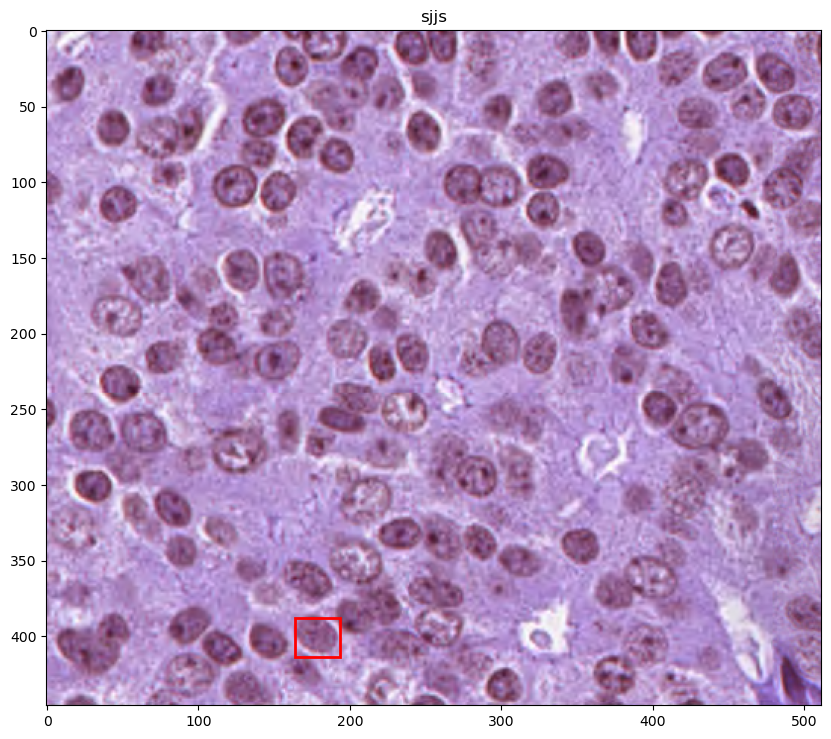

In [58]:
with open(f'../submission.json', 'r') as f:
    ff=json.load(f)
with open(f'../dataset/test_image_name_to_ids.json', 'r') as f:
    ee=json.load(f)

ind = 3
imgid = ff[ind]['image_id']
box = torch.tensor(np.array(ff[ind]['bbox'])).unsqueeze(0)
seg = ff[ind]['segmentation']
img_path = ee[imgid-1]['file_name']
img = Image.open(f'../dataset/test_release/{img_path}')
img = T.ToTensor()(img)
mask = torch.tensor(np.array(decode_maskobj(seg))).unsqueeze(0)
# for i in mask:
#     print(i)
# plt.imshow(mask)
plt.show()
show_image_with_boxes_and_masks(img, box, mask, 'sjjs')

In [ ]:
# model = torchvision.models.get_model(
#         args.model, weights=args.weights, weights_backbone=args.weights_backbone, num_classes=num_classes, **kwargs
#     )
# model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names),bias=True)
# model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4,bias=True)
# model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names),kernel_size=(1,1),stride=(1,1))

# model.to(device)

In [ ]:
model.eval()
test_loader = DataLoader(test_set, batch_size=2, shuffle=False)

results = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch.to(device))
        results.extend(outputs)

# 生成最終提交文件
with open('test-results.json', 'w') as f:
    json.dump(masks_to_coco(results, test_set.image_ids), f)

print("Submission file generated!")